# Machine Learning Pipeline - Production

Check the python kernel we are using, should be the local one, not the one in the virtual environment. <br>
NOTE: A proper virtual environment will be setup later on

In [3]:
import sys
print(sys.executable)

/usr/bin/python3


## Define Variables

Set up main variables that will be called later on, for readibility purposes

In [ ]:
install_bool = True
path_to_datasets = "/home/ieo7429/Desktop/THESIS_GAB/outfiles/target_variables/ML_tables_regression_classification_BRCA.RData"
mode = "bin_filtering"
cols_to_drop = ["mean_log2FC","weighted_log2FC", "joint_probability", "bool_diff_acc", 
                "sign_mean_log2FC_2", "sign_mean_log2FC_3", 
                "weighted_coef_of_var_log2FC", "weighted_log2FC", "bin", "Type"]

if "ampl_score" in cols_to_drop and "del_score" in cols_to_drop:
    condition = "without_CNA"
else:
    condition = "with CNA"

n_jobs = 60
nthread = 60
n_iter_bsearch = 150
n_iter_rsearch = 300

split_random_state = 489574
regressor_seed = 3737
regressor_random_state = 39473209
hypertune_random_state_bsearch = 3847
hypertune_random_state_rsearch = 49574
kfold_random_state = 4909

outer_cv = 5
inner_cv = 3
plot_variation = False
plot_gain = False
plot_shap = True

## Install packages

Install all needed packages

In [5]:
from IPython.display import clear_output

if install_bool:
    ! pip install pickleshare
    ! pip install pandas
    ! pip install scikit-learn
    ! pip install seaborn
    ! pip install scipy
    ! pip install --upgrade pip setuptools wheel
    ! pip install rpy2
    ! pip install shap
    ! pip install "numpy<=2.1"
    %pip install -U ipywidgets

clear_output(wait = False)

## Import libraries

Import all packages

In [6]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import rpy2.robjects as ro
import xgboost as xgb
import shap
import warnings
import pickleshare
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from skopt import BayesSearchCV
from sklearn.feature_selection import SelectFromModel

## Define Functions

### load_datasets_from_r
Reads "ML.Tables" .Rdata file and converts it to a nested dictionary.

In [7]:
def load_datasets_from_r(file_path):

    """ 
    The function uses rpy2 to load datasets from an RData file.
    In particular it expects a list of data.frames
    It returns a dictionary of pandas DataFrames.
    """
    
    pandas2ri.activate()

    ro.r['load'](file_path) # load the .RData

    env = ro.globalenv # set the environment

    r_list = env[list(env.keys())[0]] # take the list object

    list_names = ro.r['names'](r_list) # take the names
    list_names = [str(name) for name in list_names]

    df_dict = {} # initialize outer dictionary
    with (ro.default_converter + ro.pandas2ri.converter).context(): # start the conversion
    # the conversion transforms a list of lists of lists of data.frames 
    # to a list of dictionaries of dictionaries of dictionaries of DataFrame
        i = 0
        for outer_dict in r_list:
            df_dict[list_names[i]] = outer_dict
            i += 1
            
    return(df_dict)

### gini_coefficient

Function to compute the gini coefficient (2 * AUC - 1)

In [8]:
def gini_coefficient_score(y_true, y_pred_prob, **kwargs):
    y_score = y_pred_prob
    auc_score = sk.metrics.roc_auc_score(y_true, y_score)
    gini_coef = 2 * auc_score - 1
    return gini_coef

In [9]:
gini_coefficient = sk.metrics.make_scorer(gini_coefficient_score, response_method = "predict_proba", greater_is_better= True)

### feature_selector
his function performs Incremental Feature Selection (IFS) to produce a reduced model <br> with best gini coefficient (2 * AUC - 1) performance with cross validation.
Mean absolute SHAP values are used to select features

In [10]:
def feature_selector_shap(feature_names, feature_importances, model, 
                          X_train, X_test, y_train, inner_cv,
                          plot = True, verbose = True):

    """
    The function takes as input feature names, feature importances, 
    a XGBoost Classifier object, the training and test dataset
    and returns the reduced training and test datasets.
    - plot parameter regulates whether or not to plot the Gini Coefficient vs number of feature plot
    - verbose parameter regulates whether or not to produce a text output
    """

    thresholds = np.sort(feature_importances) # sort the feature importances
    num_features_list = [] # initialize list
    gini_coef_list = [] # initialize list
    
    for threshold in thresholds: # iterate over thresholds
        
        vars_to_keep = np.where(feature_importances >= threshold)[0]
        X_train_selected = X_train.iloc[:,vars_to_keep]

        gini_coef_scores = sk.model_selection.cross_val_score(estimator = model, 
                                                              X = X_train_selected, y = y_train, 
                                                              scoring = gini_coefficient, cv = inner_cv)
        mean_gini_coef_score = np.mean(gini_coef_scores)
        
        num_features_list.append(X_train_selected.shape[1]) # append
        gini_coef_list.append(mean_gini_coef_score) # append

        if verbose:
            print(f'> threshold={threshold}, features={X_train_selected.shape[1]}, gini coefficient={mean_gini_coef_score}')
        
        if len(vars_to_keep) == 1:
            break

    if plot:
        plt.figure(figsize=(8, 6))
        plt.plot(num_features_list, gini_coef_list, marker='o')
        plt.xlabel('Number of Selected Features')
        plt.ylabel('cross validated mean Ginny coefficient')
        plt.title('Gini coefficient vs. Number of Selected Features')
        plt.grid(True)
        plt.show()

    optimal_threshold_index = np.argmax(gini_coef_list)
    optimal_num_features = num_features_list[optimal_threshold_index]
    
    if (optimal_threshold_index) == 0:
        optimal_threshold = 0
    else:   
        optimal_threshold = thresholds[optimal_threshold_index - 1]

    if verbose:
        print(f"Optimal Threshold: {optimal_threshold:.4f}")
        print(f"Number of Selected Features: {optimal_num_features}")
        print(f"Gini coef at Optimal Threshold: {gini_coef_list[optimal_threshold_index]:.4f}")
        print("\n")
        
    n = 5
    selected_features = feature_names[np.where(feature_importances > optimal_threshold)]
    selected_features = [str(name) for name in selected_features]
    discarded_features = [str(name) for name in feature_names if str(name) not in selected_features]

    if verbose:
        print("Selected features are: \n")
        for i in range(0,len(selected_features), n):
            print("  ".join(selected_features[i:i+n]))
        print("\n")
        print("Discarded features are: \n")
        for i in range(0,len(discarded_features), n):
            print("  ".join(discarded_features[i:i+n]))

    X_train_reduced = X_train[selected_features]
    X_test_reduced = X_test[selected_features]
    
    return(X_train_reduced, X_test_reduced, selected_features)    

### Nested CV

This function performs nested cross validation, optimizing the model at each step in order to properly estimate the model's error

In [ ]:
def nested_CV(outer_cv, inner_cv,
               X_train, y_train, 
               model, search_space, 
               n_jobs, n_iter_bsearch, verbose):
    
    """
    The function performs nested cross validation to estimate model's error rate
    It take the cv number, the training dataset, the target variable, the model or a BayesSearchCV
    and a search space to perform hyperparameter tuning
    """

    kf = sk.model_selection.KFold(n_splits = outer_cv, 
                                  shuffle = True, 
                                  random_state = kfold_random_state)
    
    accuracy_array = np.zeros(outer_cv)
    f1_array = np.zeros(outer_cv)
    precision_array = np.zeros(outer_cv)
    recall_array = np.zeros(outer_cv)
    roc_auc_array = np.zeros(outer_cv)
    predictions_array = np.zeros(len(X_train))
    probas_array = np.zeros(len(X_train))
    
    i = 0
    for train_index, val_index in kf.split(X_train):

        if verbose:
            print(f"Fold #{i + 1}")
        
        if verbose:
            print("STEP 1 (Splitting)")
        
        X_train_cv, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_cv, y_val = y_train[train_index], y_train[val_index]
        
        if verbose:
            print("STEP 2 (Tuning)")

        opti = BayesSearchCV(
            estimator = model,
            search_spaces = search_space,
            n_iter = n_iter_bsearch,
            cv = inner_cv,
            random_state = hypertune_random_state_bsearch,
            refit = True,
            n_jobs = n_jobs,
            verbose = False
        )

        opti.fit(X_train_cv, y_train_cv)
        best_model = opti.best_estimator_
    
        if verbose:
            print("STEP 3 (Prediction)")

        cv_predictions = best_model.predict(X_val)
        cv_pred_probas = best_model.predict_proba(X_val)[:,1]
        
        cv_accuracy = sk.metrics.accuracy_score(y_val, cv_predictions)
        cv_f1 = sk.metrics.f1_score(y_val, cv_predictions)
        cv_precision = sk.metrics.precision_score(y_val, cv_predictions)
        cv_recall = sk.metrics.recall_score(y_val, cv_predictions)
        cv_roc_auc = sk.metrics.roc_auc_score(y_val, cv_pred_probas)
                
        accuracy_array[i] = cv_accuracy 
        f1_array[i] = cv_f1
        precision_array[i] = cv_precision
        recall_array[i] = cv_recall
        roc_auc_array[i] = cv_roc_auc
        predictions_array[val_index] = cv_predictions
        probas_array[val_index] = cv_pred_probas
        
        i += 1

    return(accuracy_array, f1_array, precision_array, recall_array, roc_auc_array, predictions_array, probas_array)

### Nested CV la vendetta

In [ ]:
def nested_CV_revenge(outer_cv, inner_cv,
                      X_train, y_train, 
                      model, search_space, 
                      n_jobs, n_iter_bsearch, verbose):
    
    """
    The function performs nested cross validation to estimate model's error rate
    It take the cv number, the training dataset, the target variable, the model or a BayesSearchCV
    and a search space to perform hyperparameter tuning
    """
    
    kf = sk.model_selection.KFold(n_splits = outer_cv, 
                                  shuffle=True, 
                                  random_state = kfold_random_state)
    

    hyperparam_list = []
    selected_features_list = []
    accuracy_array = np.zeros(outer_cv)
    f1_array = np.zeros(outer_cv)
    precision_array = np.zeros(outer_cv)
    recall_array = np.zeros(outer_cv)
    roc_auc_array = np.zeros(outer_cv)
    predictions_array = np.zeros(len(X_train))
    probas_array = np.zeros(len(X_train))
    
    i = 0
    for train_index, val_index in kf.split(X_train):

        if verbose:
            print(f"Fold #{i + 1}")
            
        if verbose:
            print("STEP 1 (Splitting)")
            
        X_train_cv, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_cv, y_val = y_train[train_index], y_train[val_index]
        
        if verbose:
            print("STEP 2 (Tuning)")

        if verbose:
            print("STEP 2.1 (HyperParameter Tuning Part 1)")
        
        opti = BayesSearchCV(
            estimator = model,
            search_spaces = search_space,
            n_iter = n_iter_bsearch,
            cv = inner_cv,
            random_state = hypertune_random_state_bsearch,
            refit = True,
            n_jobs = n_jobs,
            verbose = 0
        )
        
        opti.fit(X_train_cv, y_train_cv)
        best_model = opti.best_estimator_

        if verbose:
            print("STEP 2.2 (SHAP)")
        
        explainer = shap.TreeExplainer(best_model)

        feature_names = best_model.feature_names_in_
        feature_importances_shap = np.mean(np.abs(explainer.shap_values(X_train_cv)), axis = 0)
    
        if verbose:
            print("STEP 2.3 (Feature selection)")
        
        X_train_cv_reduced, X_val_cv_reduced, selected_features = feature_selector_shap(feature_names, feature_importances_shap, 
                                                                                        best_model, 
                                                                                        X_train_cv, X_val, y_train_cv,
                                                                                        inner_cv,
                                                                                        plot = False, verbose = False)

        if verbose:
            print("STEP 2.4 (HyperParameter Tuning Part 2)")
        
        opti_fs = BayesSearchCV(
            estimator = best_model, 
            search_spaces = search_space, 
            n_iter = n_iter_bsearch, 
            cv = inner_cv,
            random_state = hypertune_random_state_bsearch,
            refit = True, 
            n_jobs = n_jobs,
            verbose = 0
        )
        
        opti_fs.fit(X_train_cv_reduced, y_train_cv)
        best_model_fs = opti_fs.best_estimator_
        best_params_fs = opti_fs.best_params_

        if verbose: 
            print("STEP 3 (Threshold Tuning)")

        tuner_thr = sk.model_selection.TunedThresholdClassifierCV(best_model_fs, 
                                                                  scoring = "balanced_accuracy", 
                                                                  cv = inner_cv)
        
        model_thr = tuner_thr.fit(X_train_cv_reduced, y_train_cv)
        
        if verbose:
            print("STEP 4 (Prediction)")
        
        cv_predictions = model_thr.predict(X_val_cv_reduced)
        cv_pred_probas = model_thr.predict_proba(X_val_cv_reduced)[:,1]
        
        cv_accuracy = sk.metrics.accuracy_score(y_val, cv_predictions)
        cv_f1 = sk.metrics.f1_score(y_val, cv_predictions)
        cv_precision = sk.metrics.precision_score(y_val, cv_predictions)
        cv_recall = sk.metrics.recall_score(y_val, cv_predictions)
        cv_roc_auc = sk.metrics.roc_auc_score(y_val, cv_pred_probas)
        
        hyperparam_list.append(best_params_fs)
        selected_features_list.append(selected_features)
        accuracy_array[i] = cv_accuracy 
        f1_array[i] = cv_f1
        precision_array[i] = cv_precision
        recall_array[i] = cv_recall
        roc_auc_array[i] = cv_roc_auc
        predictions_array[val_index] = cv_predictions
        probas_array[val_index] = cv_pred_probas
        
        i += 1

    return(hyperparam_list, selected_features_list, 
           accuracy_array, f1_array, precision_array, 
           recall_array, roc_auc_array, predictions_array, probas_array)

## Load Data

In [13]:
output_dict = load_datasets_from_r(path_to_datasets)

In [14]:
working_df = output_dict[mode]

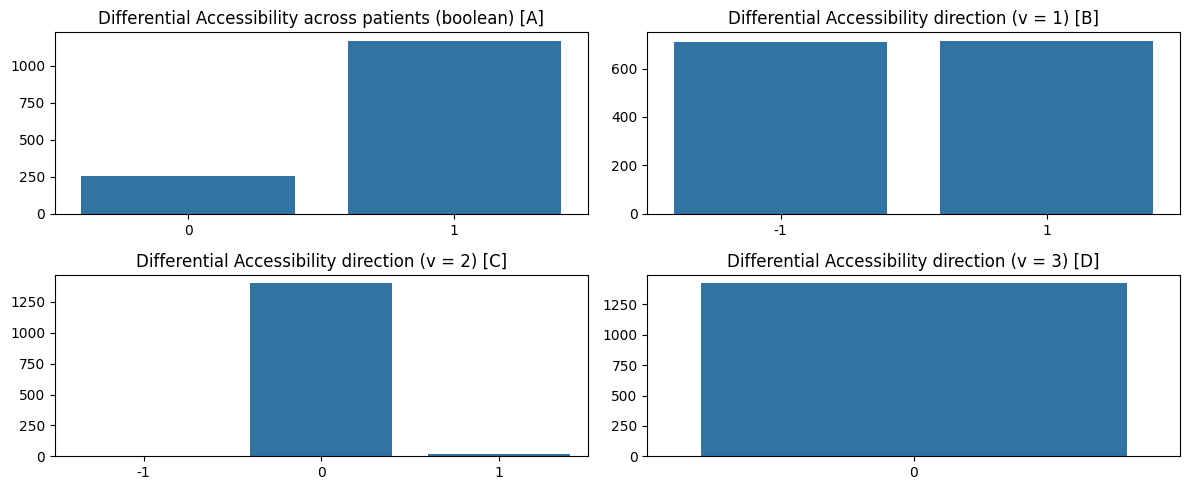

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(12, 5))

A = axes[0,0]
B = axes[0,1]
C = axes[1,0]
D = axes[1,1]

sns.barplot(working_df.bool_diff_acc.value_counts(), ax = A)
sns.barplot(working_df.sign_mean_log2FC_1.value_counts(), ax = B)
sns.barplot(working_df.sign_mean_log2FC_2.value_counts(), ax = C)
sns.barplot(working_df.sign_mean_log2FC_3.value_counts(), ax = D)

A.set_title("Differential Accessibility across patients (boolean) [A]")
B.set_title("Differential Accessibility direction (v = 1) [B]")
C.set_title("Differential Accessibility direction (v = 2) [C]")
D.set_title("Differential Accessibility direction (v = 3) [D]")

A.set_xlabel(""); A.set_ylabel("")
B.set_xlabel(""); B.set_ylabel("")
C.set_xlabel(""); C.set_ylabel("")
D.set_xlabel(""); D.set_ylabel("")

plt.tight_layout()

## Prepare Data

In [16]:
bin_ids = working_df[["bin"]]

In [17]:
working_df = working_df.drop(cols_to_drop, axis= 1)

In [18]:
X = working_df.iloc[:, 1:]
y = working_df.iloc[:, 0]

In [19]:
if "sign_mean_log2FC_1" in X.columns:
    raise Exception("Target Variable in the training set!")

In [20]:
X_train, X_test, y_train, y_test, bin_train, bin_test = sk.model_selection.train_test_split(X, y, bin_ids, test_size=0.3, random_state=123)
y_train = np.where(y_train == 1, 1, 0); y_test = np.where(y_test == 1, 1, 0)

## Prepare the Classifier and the Search Space

In [25]:
classifier = xgb.XGBClassifier(n_jobs = 40, nthread = 40, seed = 0, random_state = 42)

search_space_bayes = {  
    'learning_rate': (0.001, 1.0, 'log-uniform'),  
    'n_estimators': (50, 500),  
    'max_depth': (3, 15),  
    'min_child_weight': (1, 10),  
    'gamma': (1e-9, 5.0, 'log-uniform'),  
    'subsample': (0.5, 1.0, 'uniform'),  
    'colsample_bytree': (0.5, 1.0, 'uniform'),  
    'colsample_bylevel': (0.5, 1.0, 'uniform'),  
    'reg_alpha': (1e-9, 10.0, 'log-uniform'),  
    'reg_lambda': (1e-9, 10.0, 'log-uniform'),  
    'scale_pos_weight': (1e-6, 100, 'log-uniform'),  
    'max_delta_step': (0, 10),  
    'objective': ['binary:logistic'],  
    'booster': ['gbtree', 'dart'],  
    'eval_metric': ['logloss', 'error', 'auc']  
}  

### NESTED CV PIPELINE

In [26]:
results = nested_CV_revenge(
    outer_cv, inner_cv,
    X_train=X_train,
    y_train=y_train,
    model=classifier,
    search_space=search_space_bayes,
    n_jobs= n_jobs, n_iter_bsearch = n_iter_bsearch,
    verbose=True
)

(
    hyperparam_list,
    selected_features_list,
    accuracy_array,
    f1_array,
    precision_array,
    recall_array,
    roc_auc_array,
    predictions_array,
    probas_array
) = results


Fold #1
STEP 1 (Splitting)
STEP 2 (Tuning)
STEP 2.1 (HyperParameter Tuning Part 1)
STEP 2.2 (SHAP)
STEP 2.3 (Feature selection)
STEP 2.4 (HyperParameter Tuning Part 2)
STEP 3 (Fitting)
STEP 4 (Threshold Tuning)
STEP 4 (Prediction)
STEP 4 (Prediction)
Fold #2
STEP 1 (Splitting)
STEP 2 (Tuning)
STEP 2.1 (HyperParameter Tuning Part 1)
STEP 2.2 (SHAP)
STEP 2.3 (Feature selection)
STEP 2.4 (HyperParameter Tuning Part 2)
STEP 3 (Fitting)
STEP 4 (Threshold Tuning)
STEP 4 (Prediction)
STEP 4 (Prediction)


In [27]:
print(f"The cross-validated accuracy (cv = {outer_cv}) is : {np.mean(accuracy_array)}")
print(f"The cross-validated f1 (cv = {outer_cv}) is : {np.mean(f1_array)}")
print(f"The cross-validated precision (cv = {outer_cv}) is : {np.mean(precision_array)}")
print(f"The cross-validated R recall (cv = {outer_cv}) is : {np.mean(recall_array)}")
print(f"The cross-validated AUC (cv = {outer_cv}) is : {np.mean(roc_auc_array)}")

The cross-validated accuracy (cv = 2) is : 0.7477313681284494
The cross-validated f1 (cv = 2) is : 0.7394052076682829
The cross-validated precision (cv = 2) is : 0.7311799838034823
The cross-validated R recall (cv = 2) is : 0.7478947089666861
The cross-validated AUC (cv = 2) is : 0.8261015832785135


In [28]:
selected_features_in_at_least_one_cv = set([elem for inner_list in selected_features_list for elem in inner_list])

In [29]:
search_space_grid = {}

for dictionary in hyperparam_list:
    for k,v in dictionary.items():
        if k in search_space_grid:
            search_space_grid[k].update([v])
        else:
            search_space_grid[k] = set([v])

search_space_grid = {k : list(v) for k,v in search_space_grid.items()}

## Full Dataset Hyperparameter Tuning

In [30]:
opti = sk.model_selection.RandomizedSearchCV(estimator = classifier, 
                                             param_distributions = search_space_grid, 
                                             cv = inner_cv, 
                                             n_jobs = n_jobs,
                                             n_iter = n_iter_rsearch,
                                             random_state = hypertune_random_state_rsearch, 
                                             verbose = 3, refit = True)
opti.fit(X_train, y_train)

/home/ieo7429/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END booster=dart, colsample_bylevel=0.6263362171395246, colsample_bytree=0.5547692538151737, eval_metric=auc, gamma=0.001143548643595771, learning_rate=0.13033209244859392, max_delta_step=4, max_depth=12, min_child_weight=10, n_estimators=367, objective=binary:logistic, reg_alpha=2.702423611151236, reg_lambda=0.9285490375880117, scale_pos_weight=1.4682296559299814, subsample=0.8588319134818887;, score=0.783 total time=  11.1s
[CV 2/2] END booster=dart, colsample_bylevel=0.6263362171395246, colsample_bytree=0.5547692538151737, eval_metric=auc, gamma=0.001143548643595771, learning_rate=0.13033209244859392, max_delta_step=4, max_depth=12, min_child_weight=10, n_estimators=367, objective=binary:logistic, reg_alpha=2.702423611151236, reg_lambda=0.9285490375880117, scale_pos_weight=1.4682296559299814, subsample=0.8588319134818887;, score=0.744 total time=  11.2s


RandomizedSearchCV(cv=2,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constrain...
                                        'gamma': [0.001143548643595771],
                                        'learning_rate': [0.13033209244859392],
                                        'max_delta_step': [4],
                                        'max_depth': [12],
                                        'min_child_weight': [10],
                                        'n_estimators': [367],
                                        'objective': ['binary:logistic'],
                                        'reg_alpha': [2.702423611151236],
                                        'reg_lambda': [0.9285490375880117],
                                        'scale_pos_weight': [1.4682296559299814],
                                        'subsample': [0.8588319134818887]},
                   random_state=49574, verbose=3)

In [31]:
model = opti.best_estimator_

## Feature Importance Analysis

Let's look at both XGBoost native feature importance and at mean absolute SHAP values as metric of feature importance

In [32]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)
shap_values_numpy = explainer.shap_values(X_train)

bin_filtering / with CNA


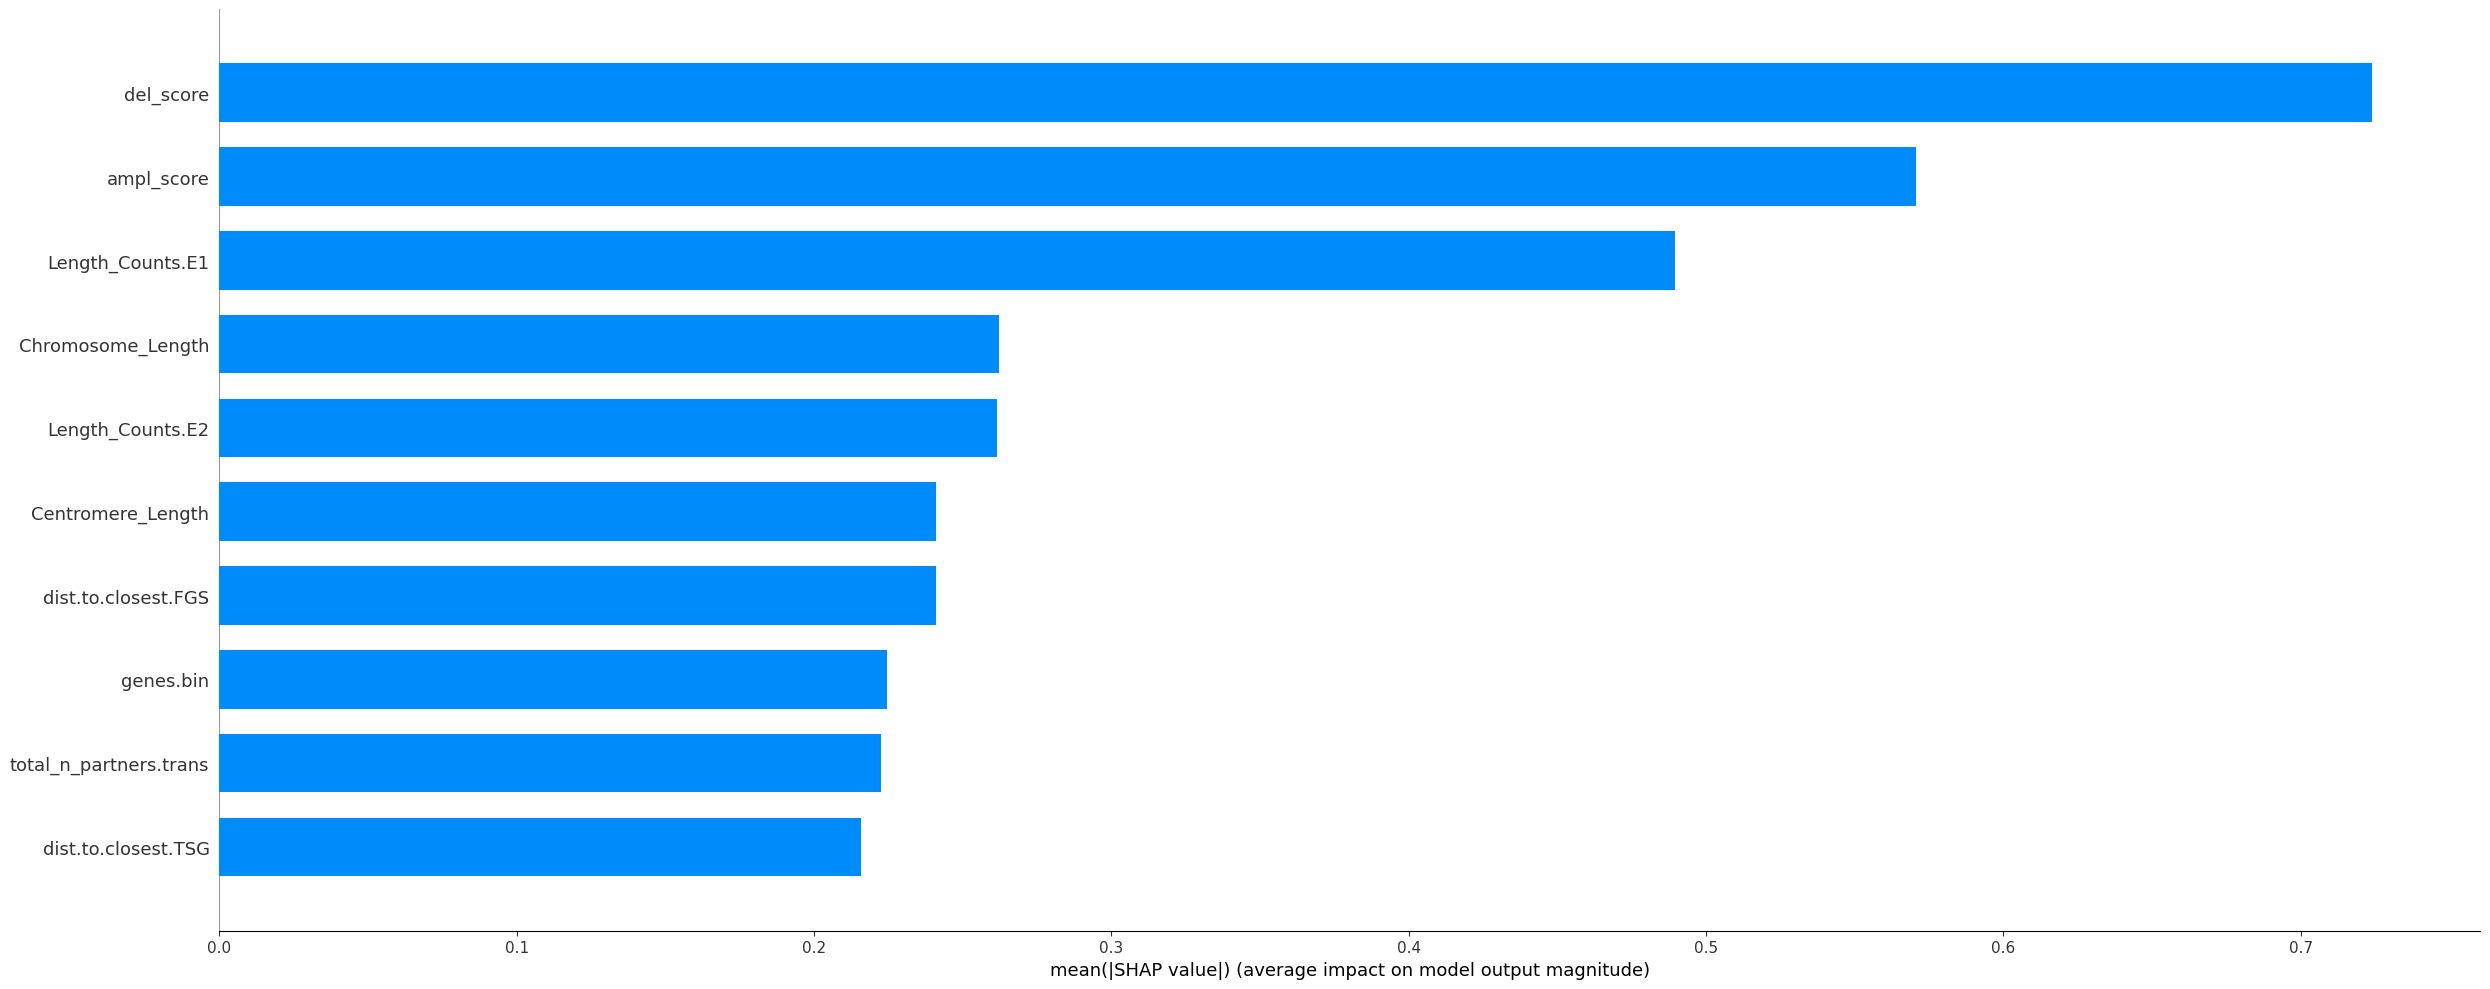

In [33]:
if plot_shap:
    print(" / ".join([mode, condition]))
    plt.figure(figsize = (100,25))
    summary_plot = shap.summary_plot(shap_values, X_train, 
                                     plot_type='bar', max_display=10, plot_size= (25,10))
    plt.show()

## Feature Selection

Let's perform Feature Selection using mean absolute SHAP values

> threshold=0.0, features=51, gini coefficient=0.6855000836093272
> threshold=0.0, features=51, gini coefficient=0.6855000836093272
> threshold=0.012465168721973896, features=49, gini coefficient=0.6668545172746854
> threshold=0.029304634779691696, features=48, gini coefficient=0.6754761987955267
> threshold=0.03603767976164818, features=47, gini coefficient=0.673678910233532
> threshold=0.04509884491562843, features=46, gini coefficient=0.6855294716639255
> threshold=0.04575662314891815, features=45, gini coefficient=0.6906498566162431
> threshold=0.052530933171510696, features=44, gini coefficient=0.688177703513838
> threshold=0.052789364010095596, features=43, gini coefficient=0.6911905718628407
> threshold=0.05441444367170334, features=42, gini coefficient=0.686105128121935
> threshold=0.05712859705090523, features=41, gini coefficient=0.6878431414145703
> threshold=0.058598048985004425, features=40, gini coefficient=0.6871693375895057
> threshold=0.06675214320421219, features=39, 

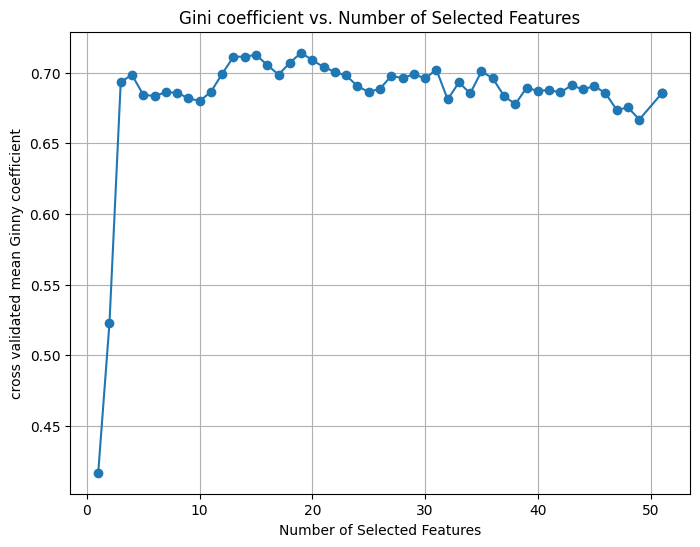

Optimal Threshold: 0.1399
Number of Selected Features: 19
Gini coef at Optimal Threshold: 0.7142


Selected features are: 

ampl_score  del_score  mean.GC.content  total_n_partners.trans  dist.to.closest.FGS
Length_Counts.E1  Length_Counts.E11  Length_Counts.E12  Length_Counts.E13  Length_Counts.E19
Length_Counts.E2  Length_Counts.E24  Length_Counts.E25  Length_Counts.E7  genes.bin
dist.to.closest.OG  dist.to.closest.TSG  Chromosome_Length  Centromere_Length


Discarded features are: 

total_n_PPIs.trans_IntINSIDER  total_n_ohnologs.mmpaper_trans  total_n_paralogs_trans  Length_Counts.E10  Length_Counts.E14
Length_Counts.E15  Length_Counts.E16  Length_Counts.E17  Length_Counts.E18  Length_Counts.E20
Length_Counts.E21  Length_Counts.E22  Length_Counts.E23  Length_Counts.E3  Length_Counts.E4
Length_Counts.E5  Length_Counts.E6  Length_Counts.E8  Length_Counts.E9  all.int.trans_IntINSIDER
partners.trans  density.OG  density.TSG  mutations_norm  distance.to.centromere
distance.to.telomere  

In [34]:
feature_names = model.feature_names_in_
feature_importances_shap = np.mean(np.abs(explainer.shap_values(X_train)), axis = 0)

X_train_reduced, X_test_reduced, selected_features = feature_selector_shap(feature_names, feature_importances_shap, 
                                                                            model, X_train, X_test, y_train, 
                                                                            inner_cv = inner_cv,
                                                                            plot = True, verbose = True)

In [ ]:
features_to_discard = [feature for feature in selected_features if feature not in selected_features_in_at_least_one_cv]

['Length_Counts.E12']

In [52]:
print(f"Dropping columns never selected during Nested Cross Validation: {features_to_discard}")

Dropping columns never selected during Nested Cross Validation: ['Length_Counts.E12']


In [49]:
X_train_reduced = X_train_reduced.drop(features_to_discard, axis = 1)
X_test_reduced = X_test_reduced.drop(features_to_discard, axis = 1)

In [36]:
opti_fs = sk.model_selection.RandomizedSearchCV(estimator = model, 
                                                param_distributions = search_space_grid, 
                                                cv = inner_cv, 
                                                n_jobs = n_jobs,
                                                n_iter = n_iter_rsearch,
                                                random_state = hypertune_random_state_rsearch, 
                                                verbose = 3, refit = True)
opti_fs.fit(X_train_reduced, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/ieo7429/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/2] END booster=dart, colsample_bylevel=0.6263362171395246, colsample_bytree=0.5547692538151737, eval_metric=auc, gamma=0.001143548643595771, learning_rate=0.13033209244859392, max_delta_step=4, max_depth=12, min_child_weight=10, n_estimators=367, objective=binary:logistic, reg_alpha=2.702423611151236, reg_lambda=0.9285490375880117, scale_pos_weight=1.4682296559299814, subsample=0.8588319134818887;, score=0.811 total time=   5.9s
[CV 2/2] END booster=dart, colsample_bylevel=0.6263362171395246, colsample_bytree=0.5547692538151737, eval_metric=auc, gamma=0.001143548643595771, learning_rate=0.13033209244859392, max_delta_step=4, max_depth=12, min_child_weight=10, n_estimators=367, objective=binary:logistic, reg_alpha=2.702423611151236, reg_lambda=0.9285490375880117, scale_pos_weight=1.4682296559299814, subsample=0.8588319134818887;, score=0.751 total time=   5.6s


RandomizedSearchCV(cv=2,
                   estimator=XGBClassifier(base_score=None, booster='dart',
                                           callbacks=None,
                                           colsample_bylevel=0.6263362171395246,
                                           colsample_bynode=None,
                                           colsample_bytree=0.5547692538151737,
                                           device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None,
                                           feature_weights=None,
                                           gamma=0.001143548643595771,
                                           grow_policy=...
                                        'gamma': [0.001143548643595771],
                                        'learning_rate': [0.13033209244859392],
                                        'max_delta_step': [4],
                                        'max_depth': [12],
                                        'min_child_weight': [10],
                                        'n_estimators': [367],
                                        'objective': ['binary:logistic'],
                                        'reg_alpha': [2.702423611151236],
                                        'reg_lambda': [0.9285490375880117],
                                        'scale_pos_weight': [1.4682296559299814],
                                        'subsample': [0.8588319134818887]},
                   random_state=49574, verbose=3)

In [37]:
model_fs = opti_fs.best_estimator_

### Optimize Classification threshold

In [38]:
tuner_thr = sk.model_selection.TunedThresholdClassifierCV(model_fs, 
                                                          scoring = "balanced_accuracy", 
                                                          cv = inner_cv)
model_thr = tuner_thr.fit(X_train_reduced, y_train)

In [39]:
accuracy_array_thr = np.mean(sk.model_selection.cross_val_score(model_thr, X_train_reduced, y_train, cv = outer_cv, scoring = "accuracy"))
f1_array_thr = np.mean(sk.model_selection.cross_val_score(model_thr, X_train_reduced, y_train, cv = outer_cv, scoring = "f1"))
precision_array_thr = np.mean(sk.model_selection.cross_val_score(model_thr, X_train_reduced, y_train, cv = outer_cv, scoring = "precision"))
recall_array_thr = np.mean(sk.model_selection.cross_val_score(model_thr, X_train_reduced, y_train, cv = outer_cv, scoring = "recall"))
roc_auc_array_thr = np.mean(sk.model_selection.cross_val_score(model_thr, X_train_reduced, y_train, cv = outer_cv, scoring = "roc_auc"))

In [40]:
print(f"The cross-validated accuracy (cv = {outer_cv}) is : {np.mean(accuracy_array_thr)}")
print(f"The cross-validated f1 score(cv = {outer_cv}) is : {np.mean(f1_array_thr)}")
print(f"The cross-validated precision (cv = {outer_cv}) is : {np.mean(precision_array_thr)}")
print(f"The cross-validated recall(cv = {outer_cv}) is : {np.mean(recall_array_thr)}")
print(f"The cross-validated roc auc (cv = {outer_cv}) is : {np.mean(roc_auc_array_thr)}")

The cross-validated accuracy (cv = 2) is : 0.7808739990141653
The cross-validated f1 score(cv = 2) is : 0.7621430198997418
The cross-validated precision (cv = 2) is : 0.7912364798426745
The cross-validated recall(cv = 2) is : 0.7352941176470589
The cross-validated roc auc (cv = 2) is : 0.8571168696168696


## Store Variables for later

In [53]:
%store X_train_reduced
%store X_test_reduced
%store y_train
%store y_test
%store bin_train
%store bin_test
%store model_thr

Stored 'X_train_reduced' (DataFrame)
Stored 'X_test_reduced' (DataFrame)
Stored 'y_train' (ndarray)
Stored 'y_test' (ndarray)
Stored 'bin_train' (DataFrame)
Stored 'bin_test' (DataFrame)
Stored 'model_thr' (TunedThresholdClassifierCV)
